Lab04 - Image Processing and Analysis Full name: Bùi Thị Thanh Phương - ID Student: 20110280

In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
from scipy import fftpack
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from pylab import imread, imsave
from skimage.color import rgb2gray
from google.colab import files

In [ ]:
def ShowImage(ImageList, nRows = 1, nCols = 2, WidthSpace = 0.00, HeightSpace = 0.00, title = None):
    gs = gridspec.GridSpec(nRows, nCols)
    gs.update(wspace=WidthSpace, hspace=HeightSpace) # set the spacing between axes.
    plt.figure(figsize=(20,10))
    for i in range(len(ImageList)):
        ax1 = plt.subplot(gs[i])
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        
        plt.subplot(nRows, nCols, i+1)
        
        image = ImageList[i].copy()
        if (len(image.shape) < 3):
            plt.imshow(image, plt.cm.gray)
        else:
            plt.imshow(image)
        if title:
            plt.title(title[i])
        else:
            plt.title("Image " + str(i))
        plt.axis('off')
    plt.show()

In [ ]:
def read_image(img_name):
    img_color = imread(img_name)
    img_gray = cv2.cvtColor(img_color, cv2.COLOR_RGB2GRAY)
    img_hsv = cv2.cvtColor(img_color, cv2.COLOR_BGR2HSV)
    return (img_color, img_gray, img_hsv)

Bài tập 1

Kiếm 1 ảnh trên internet và thực hiện các bước sau

Chuyển đổi thành ảnh xám

In [ ]:
uploads = files.upload()

Saving graph1.jpg to graph1.jpg


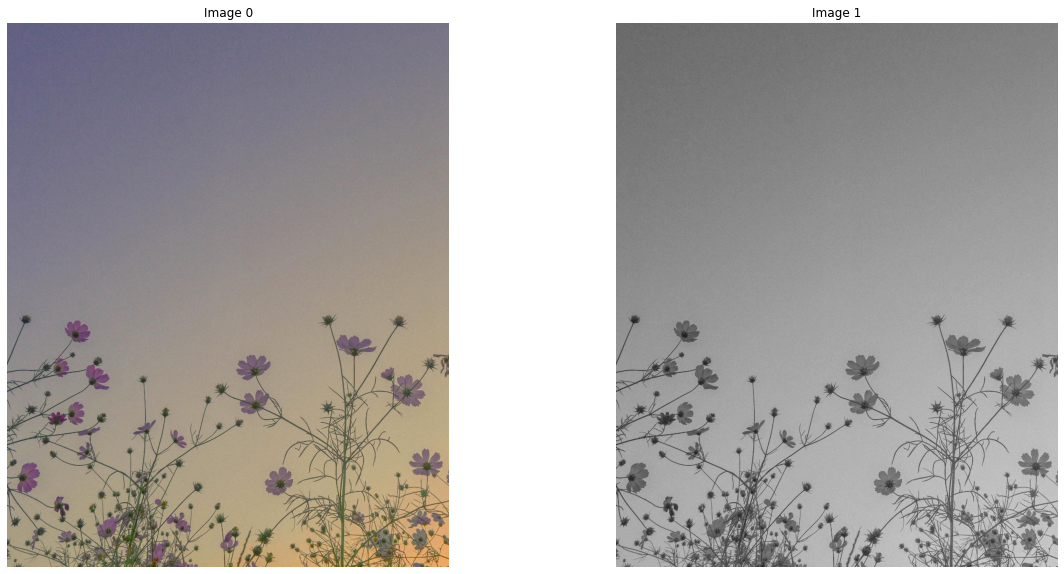

In [ ]:
# Read Image
img_color, img_gray = read_image("graph1.jpg")[:2]
# Display Image
ShowImage([img_color, img_gray], 1, 2)

Biến đổi DFT và hiển thị ảnh ở miền tần số

In [ ]:
def Image3Dto2D(image):
    if(len(image.shape) >= 3):
        image_2D = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        image_2D = image.copy()
    return image_2D

In [ ]:
def DFT_Transformation(image):
    img = Image3Dto2D(image)
    img_float32 = np.float32(img)
    dft = cv2.dft(img_float32, flags = cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))
    return magnitude_spectrum, dft_shift

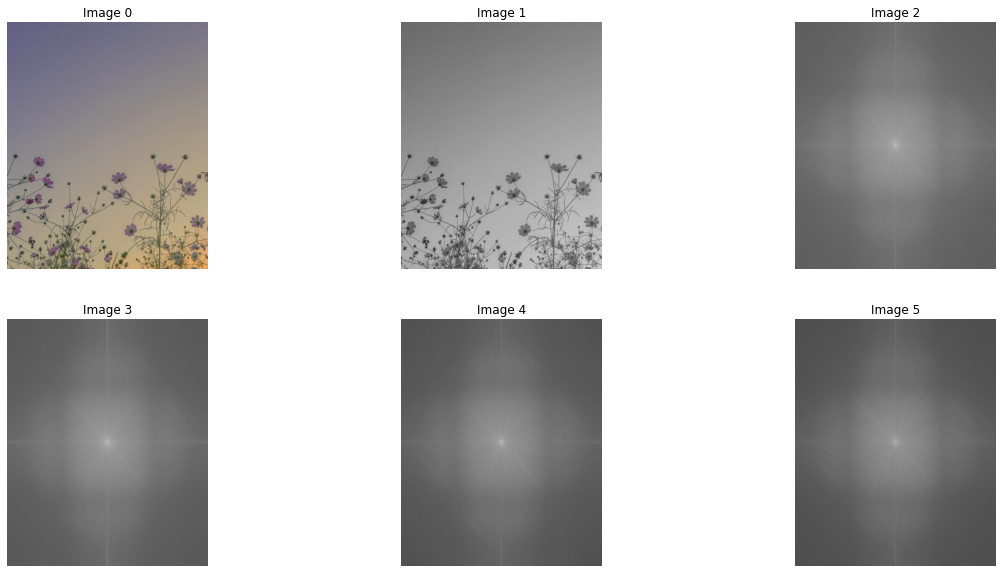

In [ ]:
img_dft_frequency, dft_shift = DFT_Transformation(img_gray)
img_dft_frequency_B, dft_shift_B = DFT_Transformation(img_color[:, :, 0])
img_dft_frequency_G, dft_shift_G = DFT_Transformation(img_color[:, :, 1])
img_dft_frequency_R, dft_shift_R = DFT_Transformation(img_color[:, :, 2])
ShowImage([img_color, img_gray, img_dft_frequency, img_dft_frequency_B, img_dft_frequency_G, img_dft_frequency_R], 2, 3)

Thực hiện tạo ảnh mask để bỏ miền tần số cao và hiển thị ảnh texture

In [ ]:
def drop_center_frequency(image_gray, size, level = 1): # level = 1 - drop high frequency, otherwise, drop low frequency
    rows, cols = img_gray.shape
    crow, ccol = rows//2, cols//2
    # create a mask first, center square is 1, remaining all zeros
    mask = np.zeros((rows, cols, 2), np.uint8)
    mask[crow - size : crow + size, ccol - size : ccol + size] = 1
    if (level == 0):
        mask = 1 - mask
    img_dft_frequency_crop = img_dft_frequency*mask[:, :, 0]
    # apply mask and inverse DFT
    fshift = dft_shift*mask
    f_ishift = np.fft.ifftshift(fshift)
    img_inverse = cv2.idft(f_ishift)
    image_inverse = cv2.magnitude(img_inverse[:,:,0], img_inverse[:,:,1])
    return mask, img_dft_frequency_crop, image_inverse

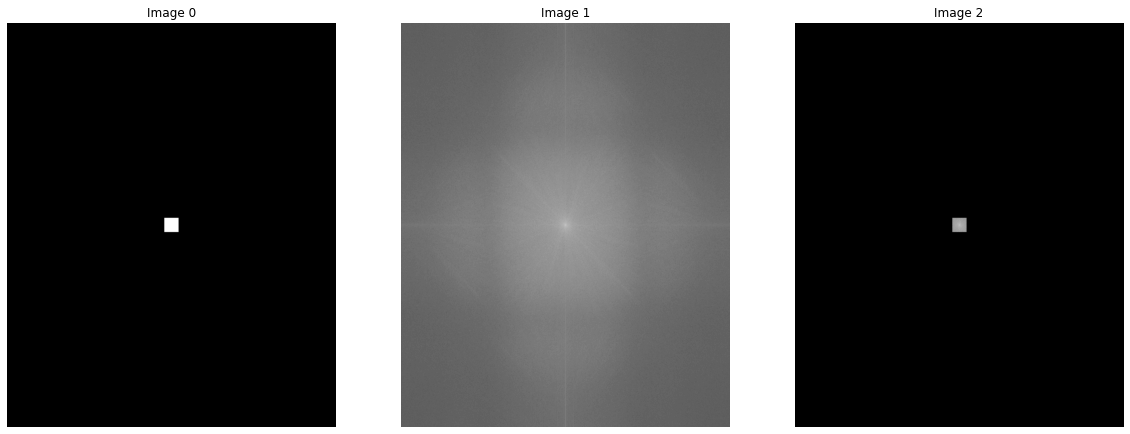

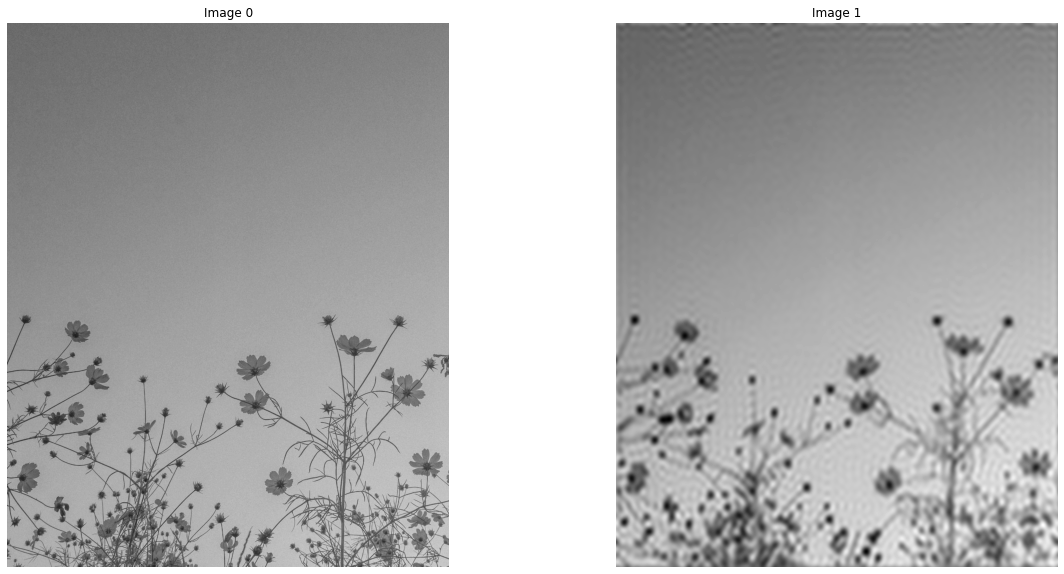

In [ ]:
mask, img_dft_frequency_crop, img_inverse = drop_center_frequency(img_gray, size = 50, level = 1)
ShowImage([mask[:,:,0], img_dft_frequency, img_dft_frequency_crop], 1, 3)
ShowImage([img_gray, img_inverse], 1, 2)

Thực hiện tạo ảnh mask để bỏ miền tần số thấp và hiển thị ảnh edge

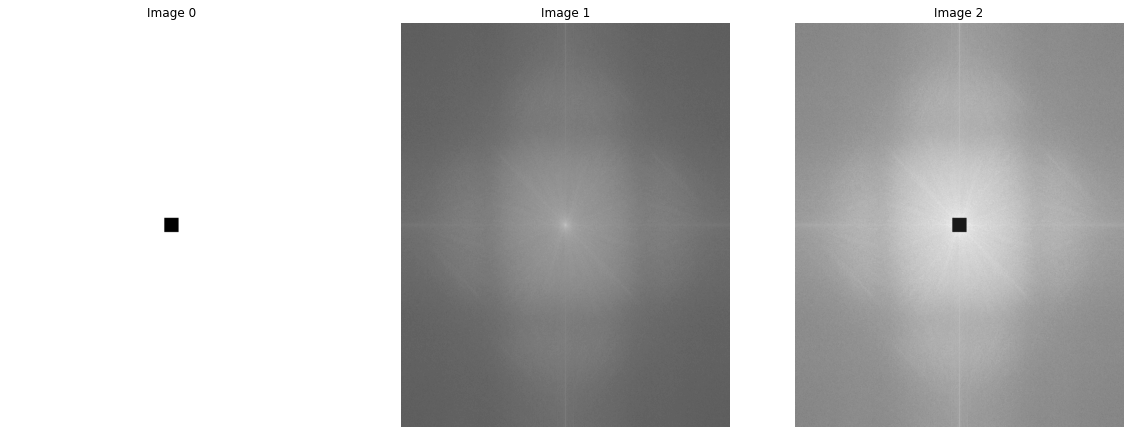

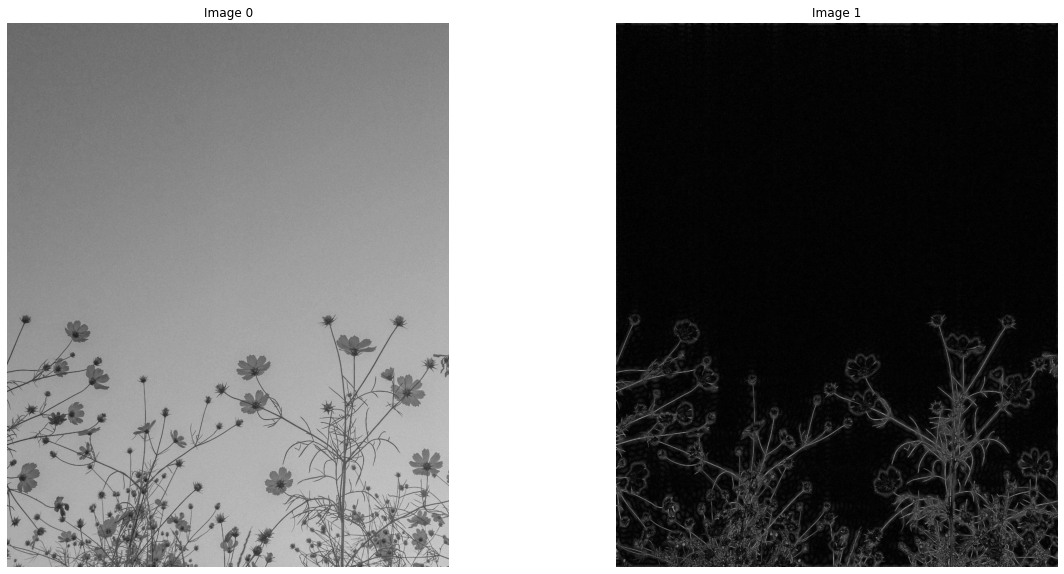

In [ ]:
mask, img_dft_frequency_crop, img_inverse = drop_center_frequency(img_gray, size = 50, level = 0)
ShowImage([mask[:,:,0], img_dft_frequency, img_dft_frequency_crop], 1, 3)
ShowImage([img_gray, img_inverse], 1, 2)

Thực hiện tạo ảnh mask như sau và thực hiện thay đổi miền tần số sau đó xuất ảnh kết quả

In [ ]:
def drop_frequency(image_gray, style=1):
    rows, cols = img_gray.shape
    crow, ccol = rows//2, cols//2
    # create a mask first, center square is 1, remaining all zeros
    mask = np.zeros((rows, cols, 2), np.uint8)
    if style:
        for x in np.arange(0, crow):
            a1 = (int)((x + 4*crow)*ccol/(5*crow))
            a2 = (int)((3*x + 2*crow)*ccol/(5*crow))
            mask[x, a2:a1] = 1
        for x in np.arange(crow, rows):
            a1 = (int)((x + 4*crow)*ccol/(5*crow))
            a2 = (int)((3*x + 2*crow)*ccol/(5*crow))
            mask[x, a1:a2] = 1
    else:
        for y in np.arange(0, ccol):
            a1 = (int)(((-1)*y + 4*ccol)*crow/(3*ccol))
            a2 = -a1
            mask[a2:a1, y] = 1
        for y in np.arange(ccol, cols):
            a1 = (int)(((-1)*y + 4*ccol)*crow/(3*ccol))
            a2 = -a1
            mask[a1:a2, y] = 1
    mask = 1 - mask
    img_dft_frequency_crop = img_dft_frequency*mask[:, :, 0]
    # apply mask and inverse DFT
    fshift = dft_shift*mask
    f_ishift = np.fft.ifftshift(fshift)
    img_inverse = cv2.idft(f_ishift)
    image_inverse = cv2.magnitude(img_inverse[:,:,0], img_inverse[:,:,1])
    return mask, img_dft_frequency_crop, image_inverse

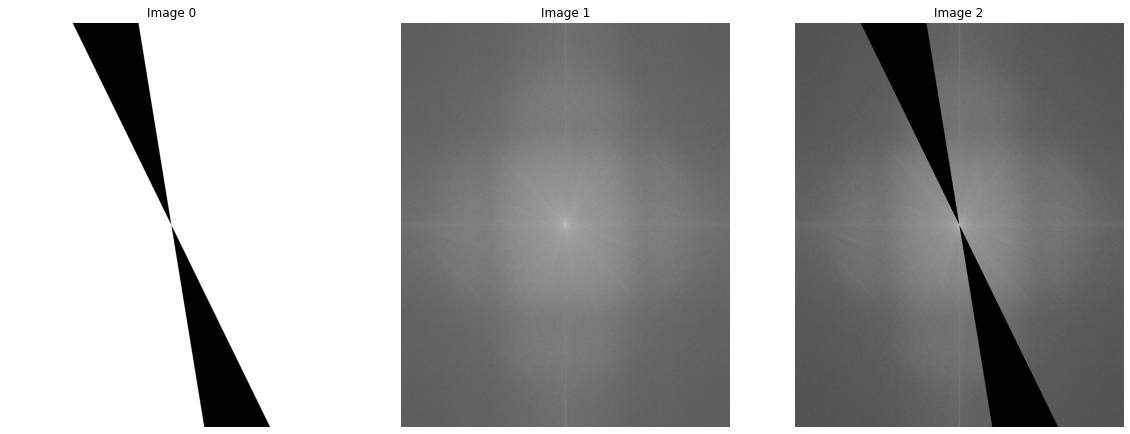

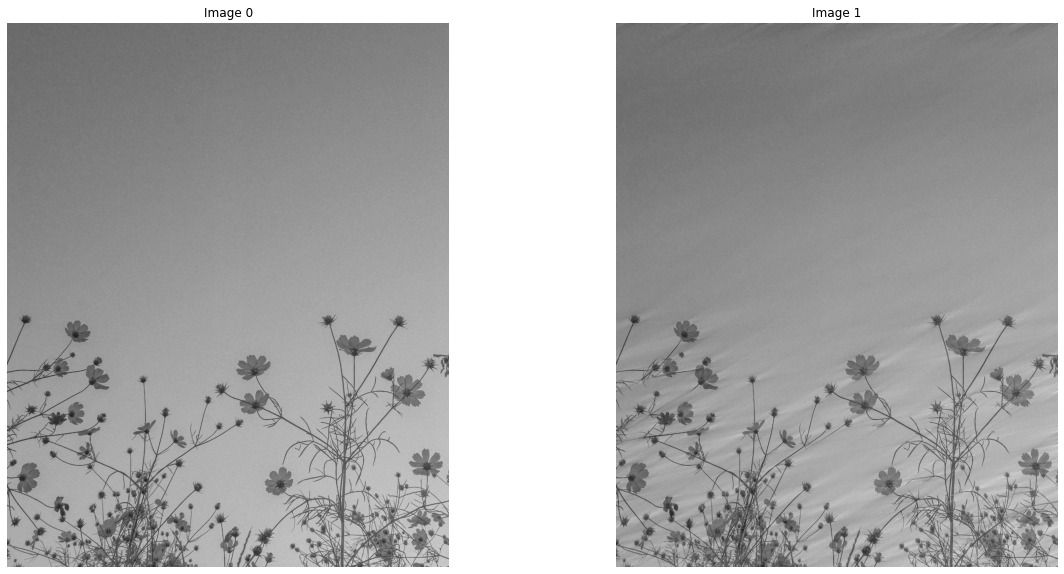

In [ ]:
mask, img_dft_frequency_crop, img_inverse = drop_frequency(img_gray, style=1)
ShowImage([mask[:,:,0], img_dft_frequency, img_dft_frequency_crop], 1, 3)
ShowImage([img_gray, img_inverse], 1, 2)

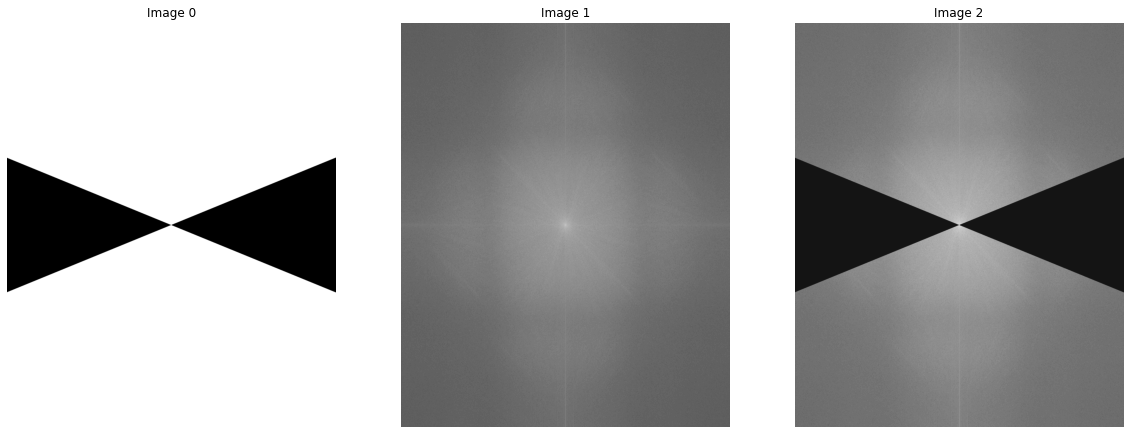

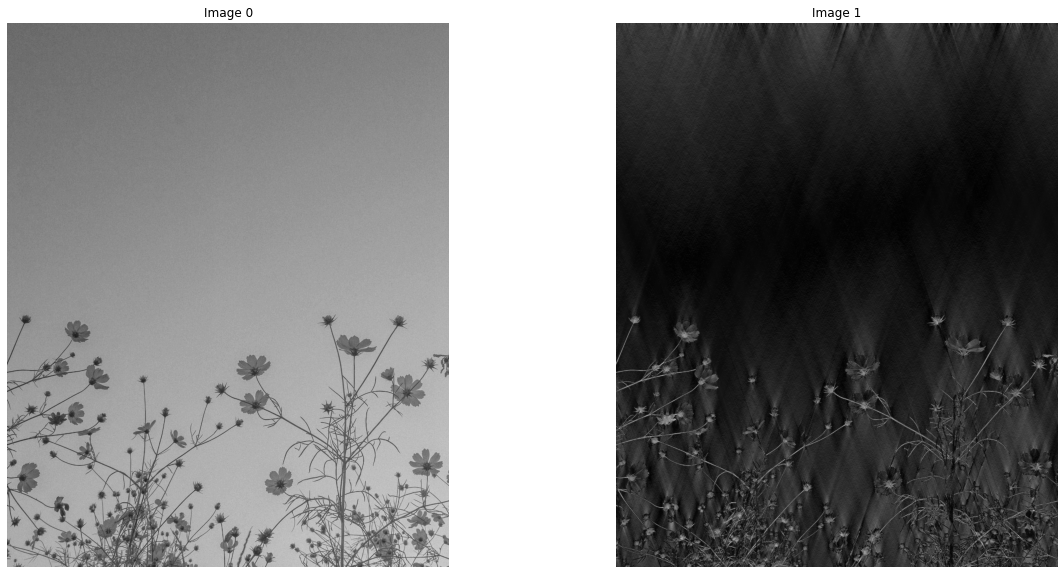

In [ ]:
mask, img_dft_frequency_crop, img_inverse = drop_frequency(img_gray, style=0)
ShowImage([mask[:,:,0], img_dft_frequency, img_dft_frequency_crop], 1, 3)
ShowImage([img_gray, img_inverse], 1, 2)

Bài tập 2

Kiếm một ảnh trên internet và thực hiện các bước sau

Chuyển đổi thành ảnh xám

In [ ]:
uploads = files.upload()

Saving graph2.jpg to graph2.jpg


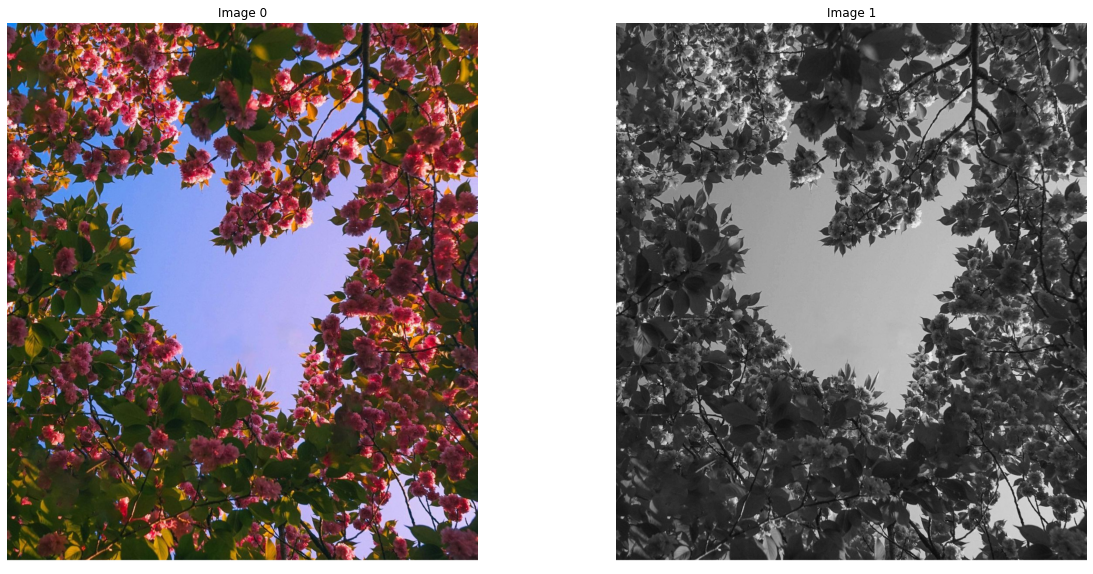

In [ ]:
# Read Image
img_color, img_gray = read_image("graph2.jpg")[:2]
# Display Image
ShowImage([img_color, img_gray], 1, 2)


Biến đổi DCT và hiển thị ảnh DCT

In [ ]:
def dct2(a):
    return fftpack.dct(fftpack.dct(a, axis=0, norm='ortho'), axis=1, norm='ortho')

def idct2(a):
    return fftpack.idct(fftpack.idct(a, axis=0, norm='ortho'), axis=1, norm='ortho')

In [ ]:
def image_compression(image2D, threshold=0.01, technique='DCT'):
    im = image2D
    imsize = im.shape
    if technique == 'DCT':
        dct = np.zeros(imsize)
        im_dct = np.zeros(imsize)
        # Do 8x8 DCT on image (in-place)
        for i in np.r_[:imsize[0]:8]:
            for j in np.r_[:imsize[1]:8]:
                dct[i:(i+8), j:(j+8)] = dct2(im[i:(i+8), j:(j+8)])
        # Threshold
        dct_thresh = dct*(abs(dct) > (threshold*np.max(dct)))
        percent_nonzeros = np.sum(dct_thresh != 0.0)/(imsize[0]*imsize[1]*1.0)
        # 8x8 iDCT
        for i in np.r_[:imsize[0]:8]:
            for j in np.r_[:imsize[1]:8]:
                im_dct[i:(i+8), j:(j+8)] = idct2(dct_thresh[i:(i+8), j:(j+8)])
        return percent_nonzeros, im_dct, dct, dct_thresh
    else:
        dft = np.zeros(imsize, dtype='complex')
        im_dft = np.zeros(imsize, dtype='complex')
        # Do 8x8 DFT on image (in-place)
        for i in np.r_[:imsize[0]:8]:
            for j in np.r_[:imsize[1]:8]:
                dft[i:(i+8), j:(j+8)] = np.fft.fft2(im[i:(i+8), j:(j+8)])
        # Threshold
        dft_thresh = dft*(abs(dft) > (threshold*np.max(abs(dft))))
        percent_nonzeros = np.sum(dft_thresh != 0.0)/(imsize[0]*imsize[1]*1.0)
        # 8x8 iDFT
        for i in np.r_[:imsize[0]:8]:
            for j in np.r_[:imsize[1]:8]:
                im_dft[i:(i+8), j:(j+8)] = np.fft.ifft2(dft_thresh[i:(i+8), j:(j+8)])
        return percent_nonzeros, abs(im_dft), dft, dft_thresh

In [ ]:
threshold = 0.0104205
percent_nonzeros, im_dct, dct, dct_thresh = image_compression(img_gray, threshold=threshold, technique='DCT')

Text(0.5, 1.0, '8x8 DCTs of the image')

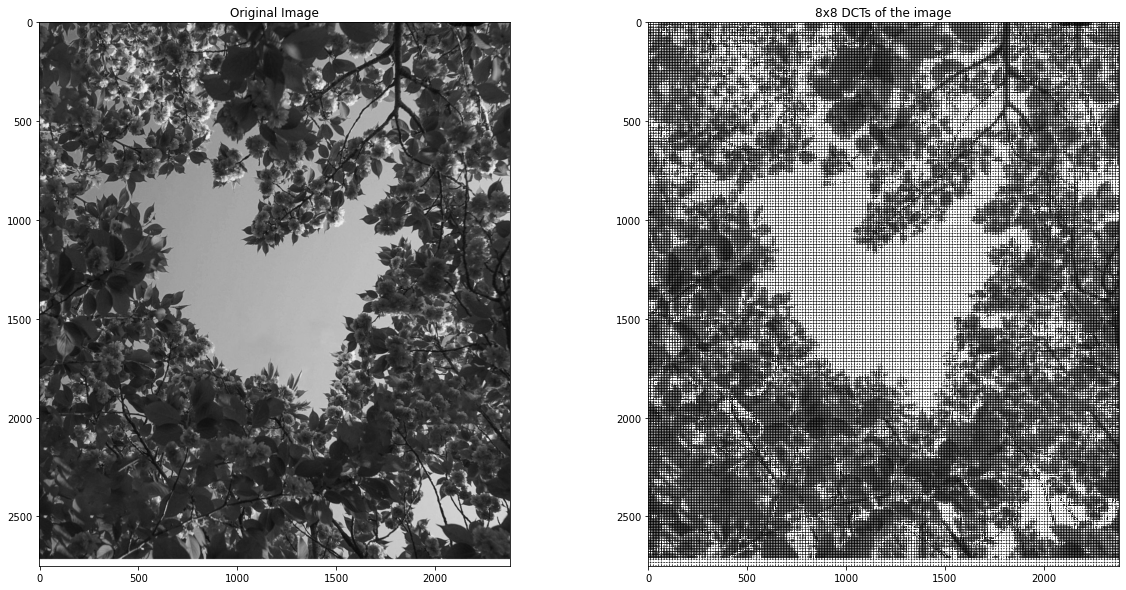

In [ ]:
# Display entire DCT
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.imshow(img_gray, cmap = 'gray')
plt.title("Original Image")
plt.subplot(1,2,2)
plt.imshow(dct, cmap='gray', vmax=np.max(dct)*0.01, vmin=0)
plt.title("8x8 DCTs of the image")

Đặt ngưỡng giữ lại khoảng 5% hệ số DCT và hiển thị ảnh nén kết quả

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(dct, cmap='gray', vmax=np.max(dct)*0.01, vmin=0)
plt.title("Original DCT Image")
plt.subplot(1,2,2)
plt.imshow(dct_thresh,cmap='gray', vmax=np.max(dct)*0.01, vmin=0)
plt.title("8x8 DCTs of the image with threshold " + str(threshold))

print("Keeping only %f%% of the DCT coefficients" % (percent_nonzeros*100.0))       
print("Comparison between orginal and DCT compressed images")
ShowImage([img_gray, im_dct])

Output hidden; open in https://colab.research.google.com to view.

Bài tập 3

Kiếm một ảnh màu trên internet và thực hiện nén các ảnh này dùng DFT và DCT bằng cách giữ lại 5% hệ số. Sau đó khôi phục lại ảnh màu và lưu xuống thư mục cũng như xuất dung lượng ảnh xem giảm được bao nhiêu dung lượng (Gợi ý dùng không gian HSV nén V nhưng vẫn giữ được màu, thử nén H và S xem sao)

In [ ]:
uploads = files.upload()

Saving graph3.jpg to graph3.jpg


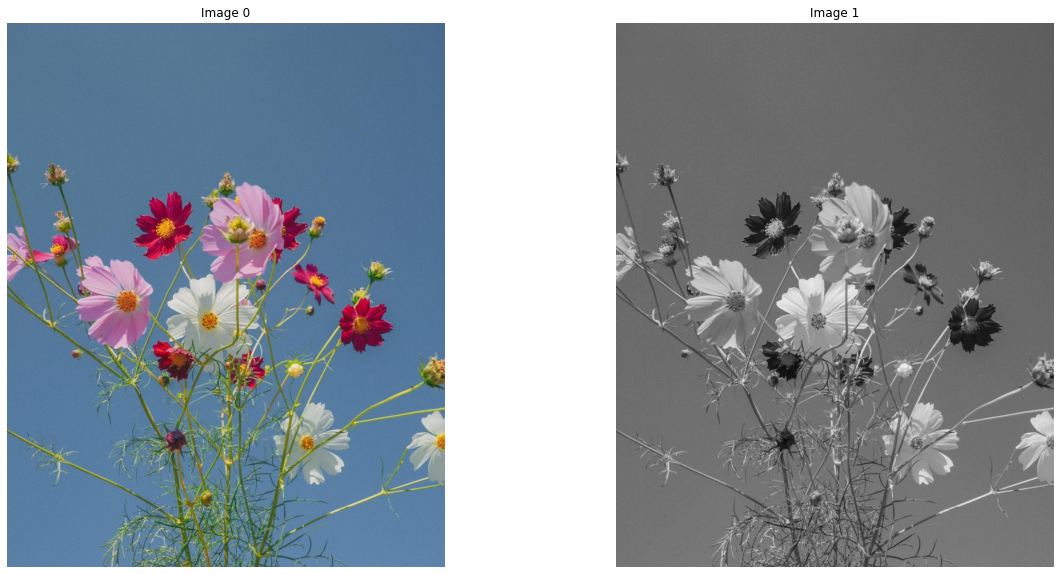

In [ ]:
# Read Image
img_color, img_gray, img_hsv = read_image("graph3.jpg")
# Display Image
ShowImage([img_color, img_gray], 1, 2)

In [ ]:
# Compression H channel
im_H = img_hsv[:, :, 0]
threshold = 0.01114
percent_nonzeros_dct_H, im_dct_H, dct_H, dct_thresh_H = image_compression(im_H, threshold=threshold, technique='DCT')
threshold = 0.0148
percent_nonzeros_dft_H, im_dft_H, dft_H, dft_thresh_H = image_compression(im_H, threshold=threshold, technique='DFT')

# Compression S channel
im_S = img_hsv[:, :, 1]
threshold = 0.006875
percent_nonzeros_dct_S, im_dct_S, dct_S, dct_thresh_S = image_compression(im_S, threshold=threshold, technique='DCT')
threshold = 0.01125
percent_nonzeros_dft_S, im_dft_S, dft_S, dft_thresh_S = image_compression(im_S, threshold=threshold, technique='DFT')

# Compression V channel
im_V = img_hsv[:, :, 2]
threshold = 0.00578
percent_nonzeros_dct_V, im_dct_V, dct_V, dct_thresh_V = image_compression(im_V, threshold=threshold, technique='DCT')
threshold = 0.011749
percent_nonzeros_dft_V, im_dft_V, dft_V, dft_thresh_V = image_compression(im_V, threshold=threshold, technique='DFT') 

In [ ]:
print("Keeping only %f%% of the DCT coefficients by H channel" % (percent_nonzeros_dct_H*100.0))
print("Keeping only %f%% of the DFT coefficients by H channel" % (percent_nonzeros_dft_H*100.0))
print("="*60)
print("Keeping only %f%% of the DCT coefficients by S channel" % (percent_nonzeros_dct_S*100.0))
print("Keeping only %f%% of the DFT coefficients by S channel" % (percent_nonzeros_dft_S*100.0))
print("="*60)
print("Keeping only %f%% of the DCT coefficients by V channel" % (percent_nonzeros_dct_V*100.0))
print("Keeping only %f%% of the DFT coefficients by V channel" % (percent_nonzeros_dft_V*100.0))

Keeping only 3.177290% of the DCT coefficients by H channel
Keeping only 3.553293% of the DFT coefficients by H channel
Keeping only 4.031852% of the DCT coefficients by S channel
Keeping only 4.503909% of the DFT coefficients by S channel
Keeping only 4.484719% of the DCT coefficients by V channel
Keeping only 3.686992% of the DFT coefficients by V channel


Khôi phục lại ảnh màu

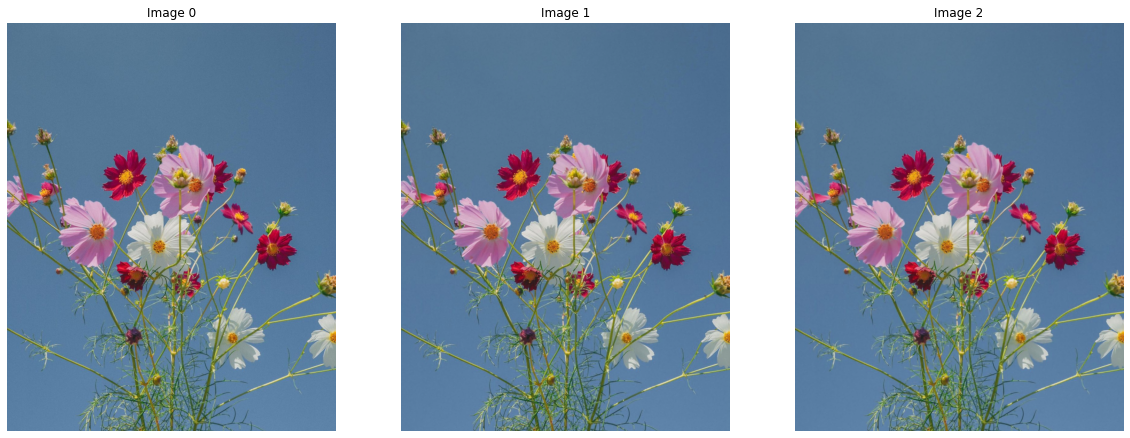

In [ ]:
img_hsv[:, :, 0] = im_dct_H
img_hsv[:, :, 1] = im_dct_S
img_hsv[:, :, 2] = im_dct_V
img_compress_dct = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR)
img_hsv[:, :, 0] = im_dft_H
img_hsv[:, :, 1] = im_dft_S
img_hsv[:, :, 2] = im_dft_V
img_compress_dft = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR)
ShowImage([img_color, img_compress_dct, img_compress_dft], 1, 3)

Lưu xuống thư mục

In [ ]:
path = 'Image_Compression_Output'
os.mkdir(path)
imsave(os.path.join(path, "dct_compression_image.jpg"), img_compress_dct)
imsave(os.path.join(path, 'dft_compression_image.jpg'), img_compress_dft)

In [ ]:
path_original = 'graph3.jpg'
path_dct = 'Image_Compression_Output/dct_compression_image.jpg'
path_dft = 'Image_Compression_Output/dft_compression_image.jpg'
size_original = os.path.getsize(path_original)
size_dct = os.path.getsize(path_dct)
size_dft = os.path.getsize(path_dft)
print("Size of original image: ", size_original)
print("Size of image after dct compressing: {}, decrease {}".format(size_dct, size_original-size_dct))
print("Size of image after dft compressing: {}, decrease {}".format(size_dft, size_original-size_dft))

Size of original image:  816370
Size of image after dct compressing: 375286, decrease 441084
Size of image after dft compressing: 369919, decrease 446451
